In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline

In [7]:
#read the data file
df =pd.read_csv('..\\data\\HR_cleaned_dataset.csv')

#define X and y
X = df.drop('left', axis=1)  # keep as DataFrame
y = df['left']
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


(11991, 18) (11991,)


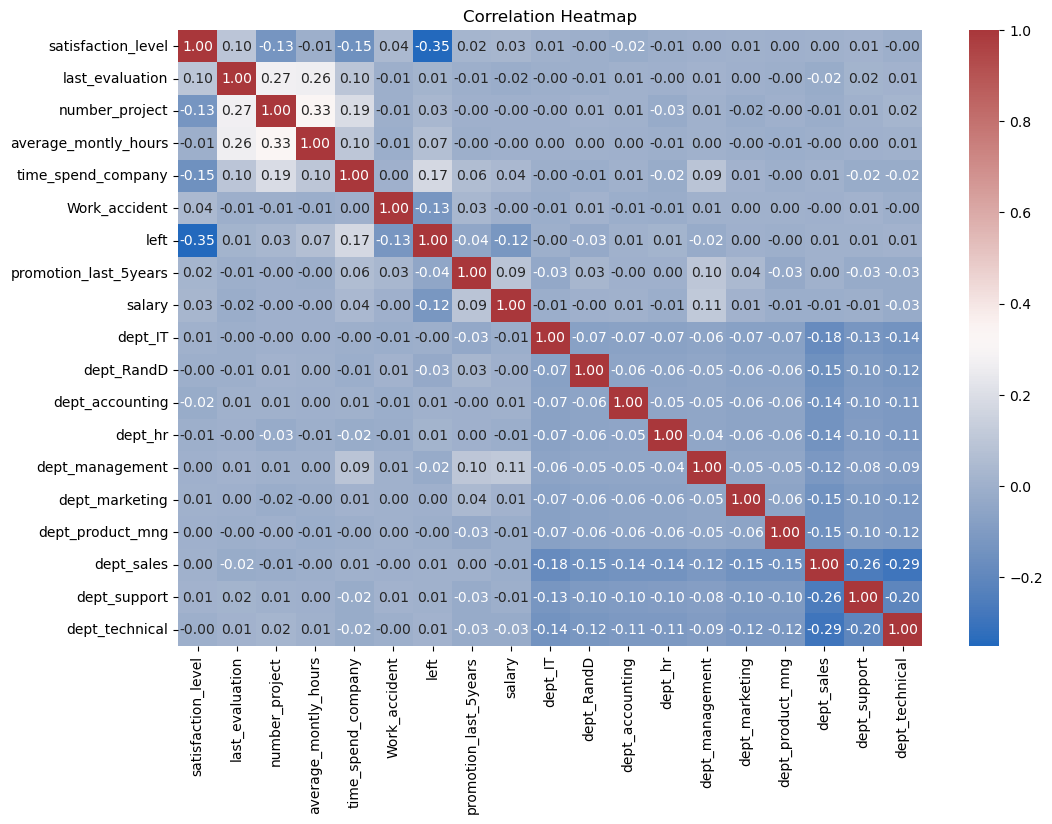

In [8]:
#correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='vlag', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
#Identify numerical and categorical features
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist() #for continuous + ordinal
cat_features = []  #for dummy variables

# Column transformer for scaling
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features)
], remainder='passthrough')

# Build Pipeline with SMOTE + Scaling + Logistic Regression
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Oversampling only on training data
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced'))
])

In [10]:
# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, n_jobs=-1) # n_jobs= -1 means using all processors
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}


[[2301  700]
 [ 110  487]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      3001
           1       0.41      0.82      0.55       597

    accuracy                           0.77      3598
   macro avg       0.68      0.79      0.70      3598
weighted avg       0.86      0.77      0.80      3598

AUC Score: 0.8374550749973346


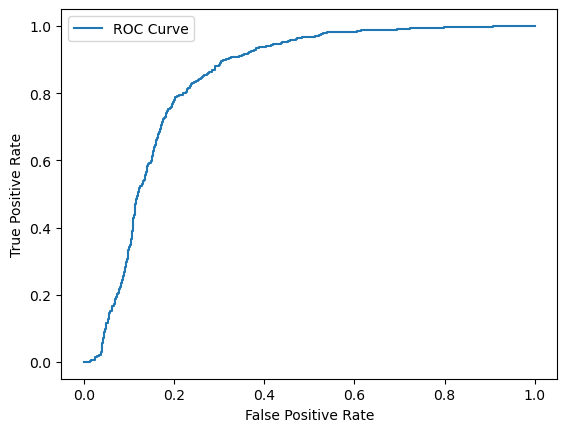

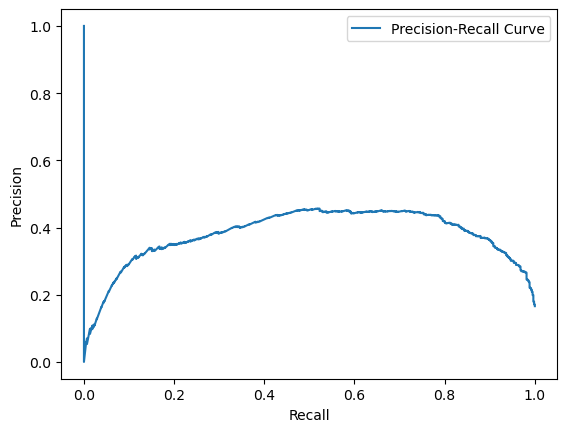

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix 
from sklearn.metrics import roc_curve, precision_recall_curve
best_model = grid_search.best_estimator_

# Trian the model on the testing set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


### Train the model on training set 

[[5341 1658]
 [ 240 1154]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      6999
           1       0.41      0.83      0.55      1394

    accuracy                           0.77      8393
   macro avg       0.68      0.80      0.70      8393
weighted avg       0.87      0.77      0.80      8393

AUC Score: 0.8378738467044791


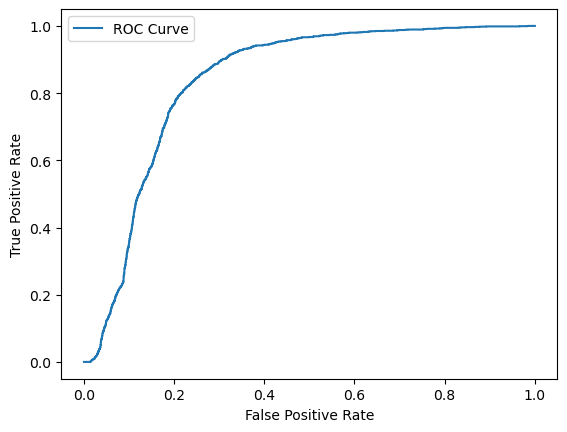

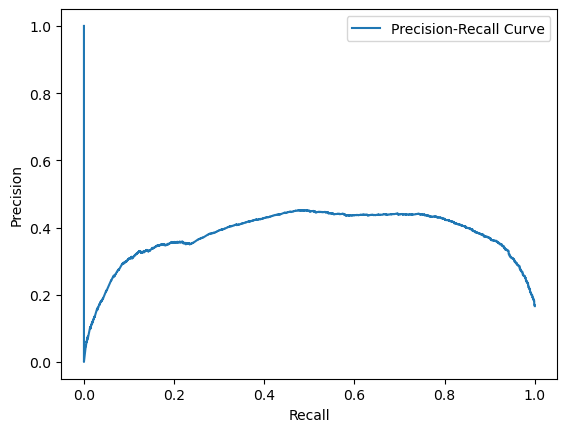

In [12]:
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]

# Metrics
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print("AUC Score:", roc_auc_score(y_train, y_train_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_train, y_train_proba)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()